# Can We Improve Results Using Covariance Feature Selection?

In [1]:
# Necessary libraries
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import pandas as pd

In [2]:
# Import data
data = pd.read_csv('kddcup.data_10_percent_corrected')
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [3]:
data.head()

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
# Remove Categorical Features
data = data.drop(['tcp', 'http', 'SF'], axis = 1)

In [5]:
# Take Random Sample
data_sample = data.sample(59000)

In [6]:
print(data.shape)
print(data_sample.shape)

(494020, 39)
(59000, 39)


In [7]:
data_sample.head()

,0,181,5450,0.1,0.2,0.3,0.4,0.5,1,0.6,...,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
386832,0,0,0,0,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
435782,0,520,0,0,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
191103,0,1032,0,0,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
311744,0,1032,0,0,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
22573,1,1380,335,0,0,0,0,0,1,0,...,150,0.63,0.05,0.01,0.01,0.0,0.0,0.0,0.0,normal.


In [8]:
# Separate source and target variables
y = data_sample[data_sample.columns[len(data_sample.columns)-1]]
print(y)
print(set(y))
print(y.shape)

386832    neptune.
435782      smurf.
191103      smurf.
311744      smurf.
22573      normal.
            ...   
362702    neptune.
394976    neptune.
190285      smurf.
174351      smurf.
343254     normal.
Name: normal., Length: 59000, dtype: object
{'back.', 'teardrop.', 'buffer_overflow.', 'loadmodule.', 'warezmaster.', 'nmap.', 'smurf.', 'guess_passwd.', 'portsweep.', 'warezclient.', 'multihop.', 'ipsweep.', 'land.', 'pod.', 'neptune.', 'ftp_write.', 'satan.', 'phf.', 'normal.', 'rootkit.'}
(59000,)


In [9]:
# Make target variables numerical
pd.set_option('mode.chained_assignment', None)
y.loc[y == 'normal.'] = 1
y.loc[y != 1] = -1
y = np.int64(y)

In [10]:
print(set(y))
print(y.shape)

{1, -1}
(59000,)


In [11]:
og_data = data_sample.iloc[:,:-1]
print(og_data)

        0   181  5450  0.1  0.2  0.3  0.4  0.5  1  0.6  ...    9  9.1  1.00.1  \
386832  0     0     0    0    0    0    0    0  0    0  ...  255    7    0.03   
435782  0   520     0    0    0    0    0    0  0    0  ...  255  255    1.00   
191103  0  1032     0    0    0    0    0    0  0    0  ...  255  255    1.00   
311744  0  1032     0    0    0    0    0    0  0    0  ...  255  255    1.00   
22573   1  1380   335    0    0    0    0    0  1    0  ...   87  150    0.63   
...    ..   ...   ...  ...  ...  ...  ...  ... ..  ...  ...  ...  ...     ...   
362702  0     0     0    0    0    0    0    0  0    0  ...  255    6    0.02   
394976  0     0     0    0    0    0    0    0  0    0  ...  255    8    0.03   
190285  0  1032     0    0    0    0    0    0  0    0  ...  255  255    1.00   
174351  0  1032     0    0    0    0    0    0  0    0  ...  255  255    1.00   
343254  0   105   146    0    0    0    0    0  0    0  ...  255  246    0.96   

        0.00.6  0.11.1  0.0

In [12]:
X9 = data_sample.iloc[:,:-1]
X9.head()
print(X9.columns)

print(X9.shape)
print(y.shape)

Index(['0', '181', '5450', '0.1', '0.2', '0.3', '0.4', '0.5', '1', '0.6',
       '0.7', '0.8', '0.9', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15',
       '8', '8.1', '0.00', '0.00.1', '0.00.2', '0.00.3', '1.00', '0.00.4',
       '0.00.5', '9', '9.1', '1.00.1', '0.00.6', '0.11.1', '0.00.7', '0.00.8',
       '0.00.9', '0.00.10', '0.00.11'],
      dtype='object')
(59000, 38)
(59000,)


In [13]:
X8 = data_sample.iloc[:,:-1]
X8.head()

,0,181,5450,0.1,0.2,0.3,0.4,0.5,1,0.6,...,9,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11
386832,0,0,0,0,0,0,0,0,0,0,...,255,7,0.03,0.06,0.00,0.00,1.0,1.0,0.0,0.0
435782,0,520,0,0,0,0,0,0,0,0,...,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
191103,0,1032,0,0,0,0,0,0,0,0,...,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
311744,0,1032,0,0,0,0,0,0,0,0,...,255,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0
22573,1,1380,335,0,0,0,0,0,1,0,...,87,150,0.63,0.05,0.01,0.01,0.0,0.0,0.0,0.0


In [14]:
X7 = data_sample.iloc[:,:-1]

In [15]:
correlated_features_9 = set()
correlation_matrix_9 = X9.corr()

correlated_features_8 = set()
correlation_matrix_8 = X8.corr()

correlated_features_7 = set()
correlation_matrix_7 = X7.corr()

In [16]:
for i in range(len(correlation_matrix_9.columns)):
    for j in range(i):
        if abs(correlation_matrix_9.iloc[i,j])>.9:
            colname = correlation_matrix_9.columns[i]
            correlated_features_9.add(colname)

In [17]:
for i in range(len(correlation_matrix_8.columns)):
    for j in range(i):
        if abs(correlation_matrix_8.iloc[i,j])>.8:
            colname = correlation_matrix_8.columns[i]
            correlated_features_8.add(colname)

In [18]:
for i in range(len(correlation_matrix_7.columns)):
    for j in range(i):
        if abs(correlation_matrix_7.iloc[i,j])>.7:
            colname = correlation_matrix_7.columns[i]
            correlated_features_7.add(colname)

In [19]:
print(len(correlated_features_9))
print(len(correlated_features_8))
print(len(correlated_features_7))


11
14
14


In [20]:
X9.drop(labels = correlated_features_9, axis = 1, inplace = True)
X8.drop(labels = correlated_features_8, axis = 1, inplace = True)
X7.drop(labels = correlated_features_7, axis = 1, inplace = True)

In [21]:
# Original Data - 38 Features
recall_scores_lof = []
precision_scores_lof = []
f1_scores_lof = []
weighted_f1_scores_lof = []
false_alarms_lof = []


def lof_calculations(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(og_data)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof.append(r)
    precision_scores_lof.append(p)
    f1_scores_lof.append(f)
    weighted_f1_scores_lof.append(wf)
    false_alarms_lof.append(false_alarm)

In [22]:
# .9+ Threshold
recall_scores_lof2 = []
precision_scores_lof2 = []
f1_scores_lof2 = []
weighted_f1_scores_lof2 = []
false_alarms_lof2 = []


def lof_calculations2(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X9)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof2.append(r)
    precision_scores_lof2.append(p)
    f1_scores_lof2.append(f)
    weighted_f1_scores_lof2.append(wf)
    false_alarms_lof2.append(false_alarm)

In [23]:
# .8+ Threshold
recall_scores_lof3 = []
precision_scores_lof3 = []
f1_scores_lof3 = []
weighted_f1_scores_lof3 = []
false_alarms_lof3 = []


def lof_calculations3(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X8)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof3.append(r)
    precision_scores_lof3.append(p)
    f1_scores_lof3.append(f)
    weighted_f1_scores_lof3.append(wf)
    false_alarms_lof3.append(false_alarm)

In [24]:
# .7+ Threshold
recall_scores_lof4 = []
precision_scores_lof4 = []
f1_scores_lof4 = []
weighted_f1_scores_lof4 = []
false_alarms_lof4 = []


def lof_calculations4(n):    
    
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X7)
    y_pred = np.array(y_pred)
    
    r = recall_score(y, y_pred, pos_label = -1)
    p = precision_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn)
   
    recall_scores_lof4.append(r)
    precision_scores_lof4.append(p)
    f1_scores_lof4.append(f)
    weighted_f1_scores_lof4.append(wf)
    false_alarms_lof4.append(false_alarm)

In [ ]:
ilist = []

i = 5
while i <= 300:
    lof_calculations(i)
    lof_calculations2(i)
    lof_calculations3(i)
    lof_calculations4(i)
    ilist.append(i)
    i = i*2

In [26]:
print(len(recall_scores_lof))
print(len(recall_scores_lof2))
print(len(recall_scores_lof3))
print(len(recall_scores_lof4))

6
6
6
6


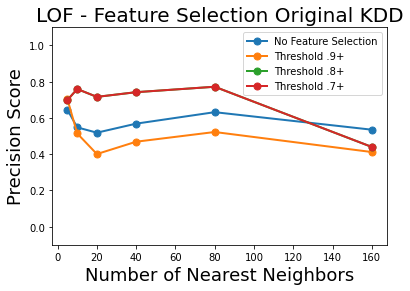

In [27]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, precision_scores_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, precision_scores_lof2, marker='o', linewidth=2, markersize=7,label='Threshold .9+')
plt.plot(ilist, precision_scores_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, precision_scores_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors',fontsize = 18)
plt.ylabel('Precision Score',fontsize = 18)
plt.title('LOF - Feature Selection Original KDD', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

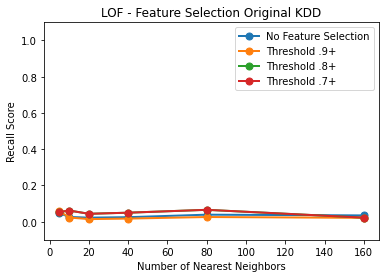

In [28]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, recall_scores_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, recall_scores_lof2, marker='o', linewidth=2, markersize=7, label='Threshold .9+')
plt.plot(ilist, recall_scores_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, recall_scores_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Recall Score')
plt.title('LOF - Feature Selection Original KDD')
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

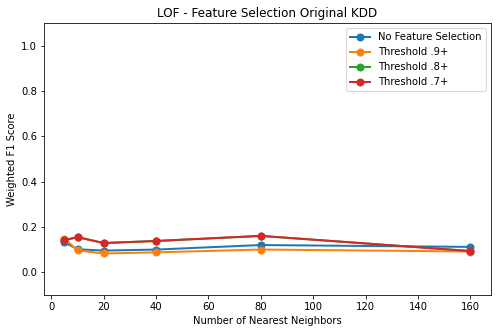

In [29]:
plt.figure(figsize = (8,5))

plt.plot(ilist, weighted_f1_scores_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, weighted_f1_scores_lof2, marker='o', linewidth=2, markersize=7, label='Threshold .9+')
plt.plot(ilist, weighted_f1_scores_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, weighted_f1_scores_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Weighted F1 Score')
plt.title('LOF - Feature Selection Original KDD')
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

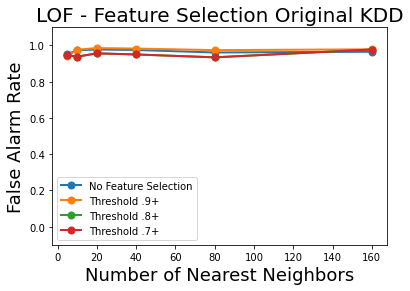

In [30]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, false_alarms_lof, marker='o', linewidth=2, markersize=7, label='No Feature Selection')
plt.plot(ilist, false_alarms_lof2, marker='o', linewidth=2, markersize=7, label='Threshold .9+')
plt.plot(ilist, false_alarms_lof3, marker='o', linewidth=2, markersize=7, label='Threshold .8+')
plt.plot(ilist, false_alarms_lof4, marker='o', linewidth=2, markersize=7, label='Threshold .7+')

    
plt.xlabel('Number of Nearest Neighbors', fontsize = 18)
plt.ylabel('False Alarm Rate', fontsize = 18)
plt.title('LOF - Feature Selection Original KDD', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

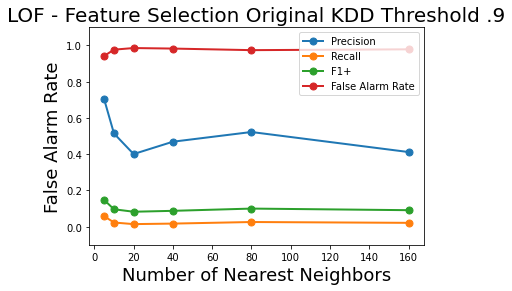

In [31]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, precision_scores_lof2, marker='o', linewidth=2, markersize=7,label='Precision')
plt.plot(ilist, recall_scores_lof2, marker='o', linewidth=2, markersize=7, label='Recall')
plt.plot(ilist, weighted_f1_scores_lof2, marker='o', linewidth=2, markersize=7, label='F1+')
plt.plot(ilist, false_alarms_lof2, marker='o', linewidth=2, markersize=7, label='False Alarm Rate')


    
plt.xlabel('Number of Nearest Neighbors', fontsize = 18)
plt.ylabel('False Alarm Rate', fontsize = 18)
plt.title('LOF - Feature Selection Original KDD Threshold .9', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

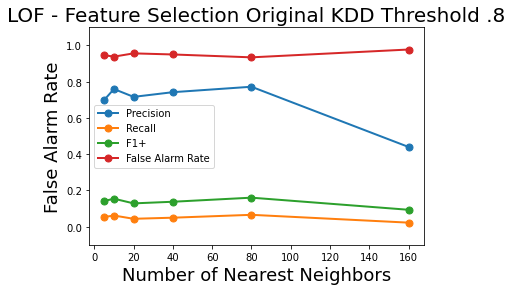

In [32]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, precision_scores_lof3, marker='o', linewidth=2, markersize=7,label='Precision')
plt.plot(ilist, recall_scores_lof3, marker='o', linewidth=2, markersize=7, label='Recall')
plt.plot(ilist, weighted_f1_scores_lof3, marker='o', linewidth=2, markersize=7, label='F1+')
plt.plot(ilist, false_alarms_lof3, marker='o', linewidth=2, markersize=7, label='False Alarm Rate')


    
plt.xlabel('Number of Nearest Neighbors', fontsize = 18)
plt.ylabel('False Alarm Rate', fontsize = 18)
plt.title('LOF - Feature Selection Original KDD Threshold .8', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

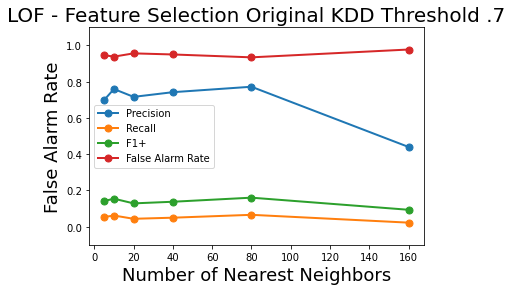

In [33]:
# plt.figure(figsize = (8,5))

plt.plot(ilist, precision_scores_lof4, marker='o', linewidth=2, markersize=7,label='Precision')
plt.plot(ilist, recall_scores_lof4, marker='o', linewidth=2, markersize=7, label='Recall')
plt.plot(ilist, weighted_f1_scores_lof4, marker='o', linewidth=2, markersize=7, label='F1+')
plt.plot(ilist, false_alarms_lof4, marker='o', linewidth=2, markersize=7, label='False Alarm Rate')


    
plt.xlabel('Number of Nearest Neighbors', fontsize = 18)
plt.ylabel('False Alarm Rate', fontsize = 18)
plt.title('LOF - Feature Selection Original KDD Threshold .7', fontsize = 20)
    
leg = plt.legend();

plt.ylim((-.1, 1.1))

plt.show()

In [34]:
# For single calculations

def single_calculation(n):
   
    lof = LocalOutlierFactor(n_neighbors = n)
    y_pred = lof.fit_predict(X7)
    y_pred = np.array(y_pred)
    
    p = precision_score(y, y_pred, pos_label = -1)
    r = recall_score(y, y_pred, pos_label = -1)
    f = f1_score(y, y_pred, pos_label = -1)
    wf = f1_score(y, y_pred, average = 'weighted')
    
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_alarm = fp/(fp+tn) 
    print('Value of Nearest Neighbor Parameter:', n)
    print('Precision:',p)
    print('Recall:',r)
    print('Weighted F1:',wf)
    print('False Alarm Rate:', false_alarm)

In [35]:
single_calculation(4)

Value of Nearest Neighbor Parameter: 4
Precision: 0.678805120910384
Recall: 0.05034180099586463
Weighted F1: 0.1367141153212937
False Alarm Rate: 0.9496581990041354


In [36]:
single_calculation(80)

Value of Nearest Neighbor Parameter: 80
Precision: 0.7722747635639622
Recall: 0.0654696598869103
Weighted F1: 0.16011125772297205
False Alarm Rate: 0.9345303401130897


In [37]:
print(max(precision_scores_lof4))
print(min(false_alarms_lof4))

0.7722747635639622
0.9345303401130897
